In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../../src")
from evaluate_gaze import EvaluateGaze

In [3]:
user_id = 18
df = pd.read_csv(f"../data/eval_data/gaze_user{user_id}_eval_9.csv")

df.head()

,flag,xl,yl,zl,xr,yr,zr,xc,yc,zc,...,ray_x,ray_y,ray_z,eye_x,eye_y,eye_z,time,frame,u,v
0,25.0,0.238473,0.190204,0.999931,0.039987,0.174575,0.999952,0.139231,0.182390,0.999941,...,0.133092,0.176383,0.975282,0.000316,-0.001710,-0.018007,75.03333,4632.0,0.175,0.104
1,25.0,0.238792,0.190631,0.999995,0.040058,0.173576,0.999994,0.139425,0.182103,0.999994,...,0.133273,0.176104,0.975308,0.000317,-0.001710,-0.018008,75.05556,4633.0,0.175,0.104
2,25.0,0.240113,0.190234,0.999924,0.040116,0.169294,0.999954,0.140116,0.179764,0.999939,...,0.133978,0.173917,0.975604,0.000322,-0.001703,-0.018013,75.06667,4634.0,0.175,0.104
3,25.0,0.239827,0.191655,0.999910,0.039035,0.151403,0.999936,0.139432,0.171529,0.999923,...,0.133498,0.166158,0.977021,0.000323,-0.001613,-0.018167,75.08889,4635.0,0.175,0.104
4,25.0,0.239688,0.191245,0.999795,0.039653,0.150045,0.999897,0.139673,0.170646,0.999846,...,0.133753,0.165335,0.977126,0.000323,-0.001609,-0.018176,75.10000,4636.0,0.175,0.104


In [4]:
# gaze direction
ray_x = df["ray_x"].values
ray_y = df["ray_y"].values
ray_z = df["ray_z"].values

# gaze direction at z=1
xe = ray_x[:] / ray_z[:] * 1.0
ye = ray_y[:] / ray_z[:] * 1.0

# marker position on a calibration plane at 1m away (HMD coordinates)
p = df["u"].values
q = df["v"].values

# origin (HMD coordinates)
eye_x = df["eye_x"].values
eye_y = df["eye_y"].values
eye_z = df["eye_z"].values

# gaze position on a calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(eye_z)
t = (ones - eye_z) / ray_z
xh = eye_x + t * ray_x
yh = eye_y + t * ray_y

## Evaluate raw gaze direction

In [5]:
param_raw = [0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
param_raw

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

In [6]:
rmse_raw = EvaluateGaze.err_rmse_reg(param_raw, xe, ye, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_raw}")

angle_err = np.rad2deg(np.arctan(rmse_raw))
print(f"angle_err: {angle_err}")

RMSE: 0.1110379706993094
angle_err: 6.3360521811063775


## Evaluate visual axis

In [7]:
pramm_vis = pd.read_csv(f"../param/baseline_param.csv").values[user_id-1]
pramm_vis

array([-0.01054411,  1.28465874,  0.05236441, -0.10680089,  0.05240747,
        1.18491831])

In [8]:
# calibrate gaze direction
calib_xe, calib_ye = EvaluateGaze.calibrate_reg(pramm_vis, xe, ye)

# convert gaze position on calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(calib_xe)
t = (ones - eye_z) / 1.0
calib_xh = eye_x + t * calib_xe
calib_yh = eye_y + t * calib_ye

In [9]:
rmse_vis = EvaluateGaze.err_rmse_reg(pramm_vis, xe, ye, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_vis}")

angle_err = np.rad2deg(np.arctan(rmse_vis))
print(f"angle_err: {angle_err}")

RMSE: 0.01744717791989352
angle_err: 0.9995482452881691


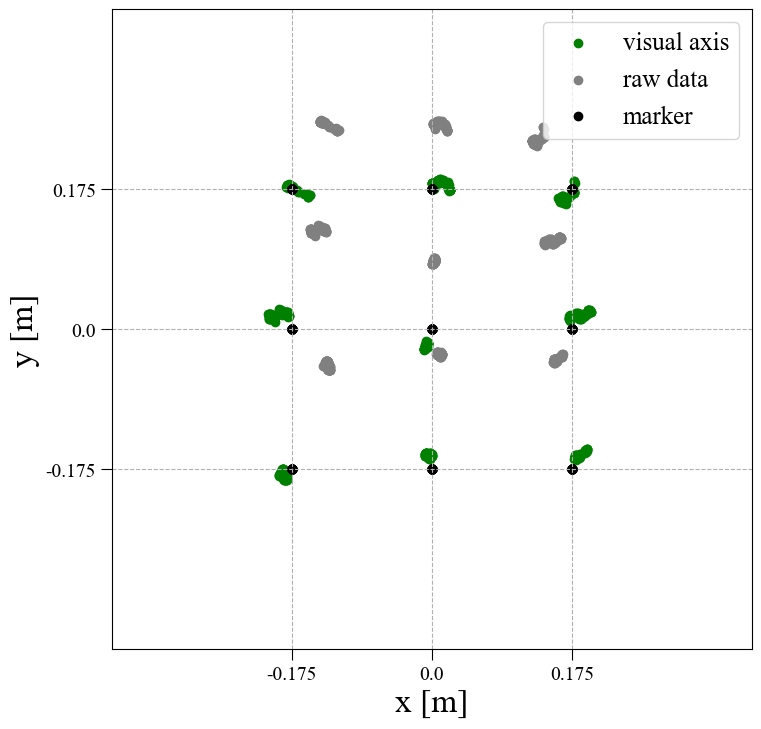

In [10]:
label_xy = [-0.7/4, 0.0, 0.7/4]

# キャリブレーション後
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor("white")

plt.scatter(calib_xh, calib_yh, c="green", label="visual axis")
plt.scatter(xh, yh, c="gray", label="raw data")
plt.scatter(p, q, c="black", label="marker")

plt.xlabel("x [m]",  size=24)
plt.ylabel("y [m]",  size=24)

plt.xlim(-0.4, 0.4)
plt.ylim(-0.4-0.071, 0.4-0.071)
plt.xticks([-0.175, 0.0, 0.175], label_xy, fontsize=14)
plt.yticks([-0.175-0.071, -0.071, 0.175-0.071], label_xy, fontsize=14)

plt.grid(which="major", axis="both", linestyle='--')
plt.tick_params(length=8)
plt.legend(fontsize=18, loc="upper right")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()

## Evaluate optical axis

In [11]:
param_opt = EvaluateGaze.get_rotation([-1.021, -3.306]).flatten()
param_opt

array([ 0.99984123, -0.00102759, -0.01778921,  0.        ,  0.99833578,
       -0.05766857,  0.01781887,  0.05765942,  0.99817728])

In [12]:
r = np.sqrt(calib_xe * calib_xe + calib_ye * calib_ye + 1)
ray = np.stack([calib_xe/r, calib_ye/r, 1/r], axis=1)
ray.shape

(564, 3)

In [13]:
# calibrate gaze direction
calib_ray = EvaluateGaze.calibrate_3d(param_opt, ray)

# calculate gaze direction at z=1
calib_xe2 = calib_ray[:, 0] / calib_ray[:, 2] * 1.0
calib_ye2 = calib_ray[:, 1] / calib_ray[:, 2] * 1.0

# convert gaze position on calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(calib_xe2)
t = (ones - eye_z) / 1.0
calib_xh2 = eye_x + t * calib_xe2
calib_yh2 = eye_y + t * calib_ye2

In [14]:
rmse_opt = EvaluateGaze.err_rmse_3d(param_opt, ray, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_opt}")

angle_err = np.rad2deg(np.arctan(rmse_opt))
print(f"angle_err: {angle_err}")

RMSE: 0.06031807529979345
angle_err: 3.451789016382559


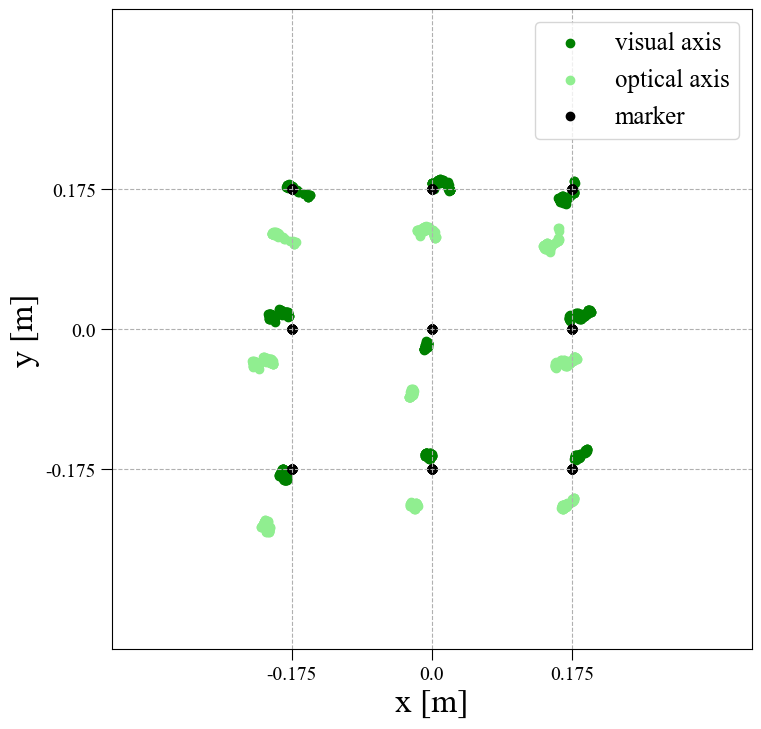

In [15]:
label_xy = [-0.7/4, 0.0, 0.7/4]

# キャリブレーション後
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor("white")

plt.scatter(calib_xh, calib_yh, c="green", label="visual axis")
plt.scatter(calib_xh2, calib_yh2, c="lightgreen", label="optical axis")
plt.scatter(p, q, c="black", label="marker")

plt.xlabel("x [m]",  size=24)
plt.ylabel("y [m]",  size=24)

plt.xlim(-0.4, 0.4)
plt.ylim(-0.4-0.071, 0.4-0.071)
plt.xticks([-0.175, 0.0, 0.175], label_xy, fontsize=14)
plt.yticks([-0.175-0.071, -0.071, 0.175-0.071], label_xy, fontsize=14)

plt.grid(which="major", axis="both", linestyle='--')
plt.tick_params(length=8)
plt.legend(fontsize=18, loc="upper right")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()